In [83]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [84]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# Number of classes

In [85]:
NUM_CLASSES = 6

# Reading training data

In [86]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [87]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [89]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [90]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                860       
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 66        
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [92]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [93]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
33/33 [==============================] - 1s 9ms/step - loss: 1.6784 - accuracy: 0.2778 - val_loss: 1.5242 - val_accuracy: 0.3810

Epoch 00001: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 2/1000
33/33 [==============================] - 0s 6ms/step - loss: 1.5562 - accuracy: 0.3267 - val_loss: 1.4179 - val_accuracy: 0.4675

Epoch 00002: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 3/1000
33/33 [==============================] - 0s 5ms/step - loss: 1.4850 - accuracy: 0.3741 - val_loss: 1.3221 - val_accuracy: 0.5054

Epoch 00003: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 4/1000
33/33 [==============================] - 0s 7ms/step - loss: 1.4183 - accuracy: 0.4103 - val_loss: 1.2494 - val_accuracy: 0.5361

Epoch 00004: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 5/1000
33/33 [==============================] - 0s 5ms/step - loss: 1.3740 - accuracy: 0.4235 - val_lo

In [94]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 4ms/step - loss: 0.2659 - accuracy: 0.9414


In [95]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [96]:
# Model prediction - Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[3.8985107e-03 9.6702421e-01 2.8911909e-02 9.1796863e-07 5.4402518e-09
 1.6446214e-04]
1


# mixed row

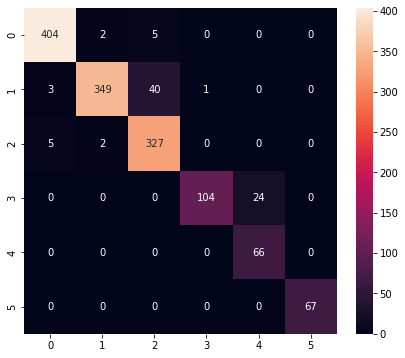

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       411
           1       0.99      0.89      0.94       393
           2       0.88      0.98      0.93       334
           3       0.99      0.81      0.89       128
           4       0.73      1.00      0.85        66
           5       1.00      1.00      1.00        67

    accuracy                           0.94      1399
   macro avg       0.93      0.94      0.93      1399
weighted avg       0.95      0.94      0.94      1399



In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [98]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [99]:
# Transforming the model (quantization)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/1g/s4np5m1x71dfjtdf1cfm3l2w0000gs/T/tmptw3356by/assets


INFO:tensorflow:Assets written to: /var/folders/1g/s4np5m1x71dfjtdf1cfm3l2w0000gs/T/tmptw3356by/assets
2022-04-12 22:42:52.404459: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-04-12 22:42:52.404631: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-04-12 22:42:52.407499: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.007ms.
  function_optimizer: function_optimizer did nothing. time = 0.002ms.

2022-04-12 22:42:52.656088: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2022-04-12 22:42:52.656165: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2022-04-12 22:42:52.706919: I tensorfl

6512

# Inference test

In [100]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [101]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [102]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [103]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 72 µs, sys: 54 µs, total: 126 µs
Wall time: 133 µs


In [104]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.8985126e-03 9.6702421e-01 2.8911917e-02 9.1796863e-07 5.4402518e-09
 1.6446214e-04]
1
